In [1]:
%load_ext autoreload
%autoreload 2


from utils import *

       time  magnitude  parent
0  0.171661   0.223379     0.0
1  0.171661   0.365045     0.0
2  1.384020   0.703963     0.0
3  3.207922   0.802740     0.0
4  5.593300   0.135634     0.0
             time  magnitude   parent
26416  10656.1810   4.228861  26414.0
54236  20739.1700   4.129038  54235.0
10625   3953.9873   4.071137  10623.0
33791  13206.6400   3.979572  33783.0
1285     328.4484   3.926272    784.0


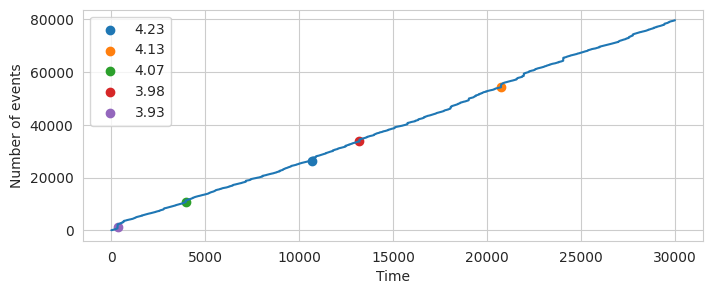

In [2]:
seq = etas(engine='rust', t_end=30000)
df = pd.DataFrame(seq, columns=['time', 'magnitude', 'parent'])
print(df.head())
plt.figure(figsize=(8, 3))
high_mags = df.magnitude.sort_values(ascending=False).index[:5]
print(df.iloc[high_mags])
plt.plot(df.time, df.index + 1)
for idx in high_mags:
    time = df.time.iloc[idx]
    magnitude = df.magnitude.iloc[idx]
    plt.scatter(time, idx + 1, label=f'{magnitude:.2f}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of events')
plt.savefig('../images/beamer/en/seq.png', dpi=200, bbox_inches='tight')
plt.show()

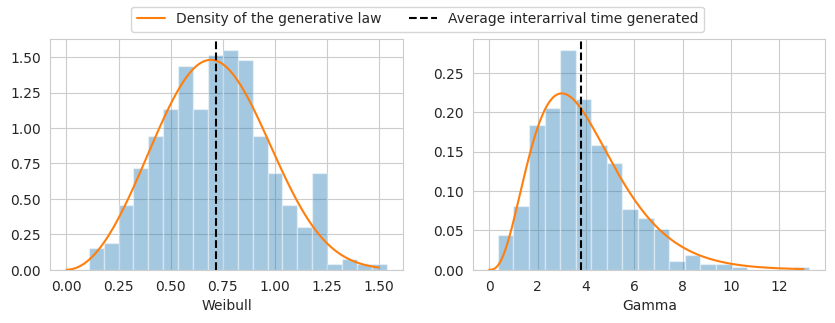

In [6]:
b = 2
k = 3
dist = Weibull(b, k)
arrival_times = np.cumsum(dist.sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

epochs = 100

model = Model(C=32, dist=Weibull, R=3)
history = model.fit(inter_times, seq_lengths, t_end, epochs, verbose=0)
generated_data, seq_lengths = model.generate(1, t_end * 3)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

diff = np.diff(generated_data[0])
axes[0].hist(diff, bins=20, density=True, alpha=0.4)
x = np.linspace(0, 1.5, 1000)
axes[0].plot(x, dist.prob(x), label='Density of the generative law')
axes[0].axvline(np.mean(diff), linestyle='--', color='black',
                label='Average interarrival time generated')
axes[0].set_xlabel('Weibull')

alpha = 4
beta = 1
dist = Gamma(alpha, beta)
arrival_times = np.cumsum(dist.sample([100, 150]), -1)
t_end = np.min(arrival_times[:, -1]) - 10
seq_lengths = np.sum(arrival_times < t_end, -1)
inter_times, _, seq_lengths, _ = create_training_dataset(
    [np.stack([s[:l], s[:l]], -1) for s, l in zip(arrival_times, seq_lengths)],
    t_end
)

model = Model(C=32, dist=Weibull, R=3)
history = model.fit(inter_times, seq_lengths, t_end, epochs, verbose=0)
generated_data, seq_lengths = model.generate(1, t_end * 3)

diff = np.diff(generated_data[0])
axes[1].hist(diff, bins=20, density=True, alpha=0.4)
x = np.linspace(0, 13, 1000)
axes[1].plot(x, dist.prob(x))
axes[1].axvline(np.mean(diff), linestyle='--', color='black')
axes[1].set_xlabel('Gamma')

fig.legend(loc='upper center', ncol=2)
plt.savefig('../images/beamer/en/gen_dist_cmp.png', dpi=200,
            bbox_inches='tight')
plt.show()

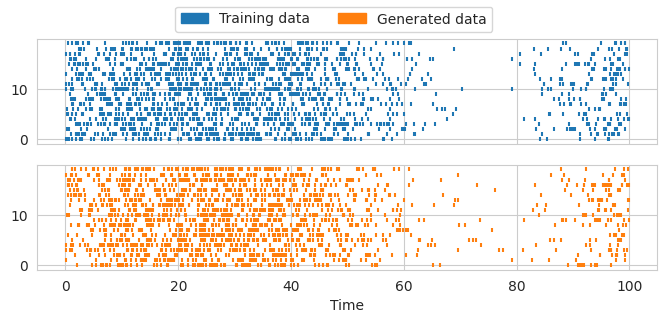

In [7]:
inter_times, seq_lengths, t_end = pickle.load(open('../data/shchur.pkl', 'rb'))
model = Model(C=32, dist=Weibull, R=10)
history = model.fit(inter_times, seq_lengths, t_end, 300, verbose=0)

num_sequences = 20
arrival_times = np.cumsum(inter_times, -1)
gen_arrival_times, gen_seq_lengths = model.generate(num_sequences, t_end)

fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True)

for i, seq in enumerate(arrival_times[:num_sequences]):
    t = seq[:seq_lengths[i]]
    axes[0].scatter(t, np.ones_like(t) * i, marker='|', s=10, c='C0')
left_patch = mpatches.Patch(color='C0', label='Training data')

for i, seq in enumerate(gen_arrival_times):
    t = seq[:gen_seq_lengths[i]]
    axes[1].scatter(t, np.ones_like(t) * i, marker='|', s=10, c='C1')
axes[1].set_xlabel('Time')
right_patch = mpatches.Patch(color='C1', label='Generated data')

fig.legend(handles=[left_patch, right_patch], loc='upper center', ncol=2)
plt.savefig('../images/beamer/en/gen_data.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=100, max_len=250, t_end=100)

model = Model(C=32, dist=Weibull, R=5, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200,
                    magnitudes, verbose=1)

Loss at epoch    1:   -5.191
Loss at epoch   10:   -7.614
Loss at epoch   20:   -8.212
Loss at epoch   30:   -8.340
Loss at epoch   40:   -8.492
Loss at epoch   50:   -8.613
Loss at epoch   60:   -8.703
Loss at epoch   70:   -8.770
Loss at epoch   80:   -8.819
Loss at epoch   90:   -8.880
Loss at epoch  100:   -8.932
Loss at epoch  110:   -8.979
Loss at epoch  120:   -9.016
Loss at epoch  130:   -9.049
Loss at epoch  140:   -9.083
Loss at epoch  150:   -9.104
Loss at epoch  160:   -9.127
Loss at epoch  170:   -9.164
Loss at epoch  180:   -9.192
Loss at epoch  190:   -9.205
Loss at epoch  200:   -9.232


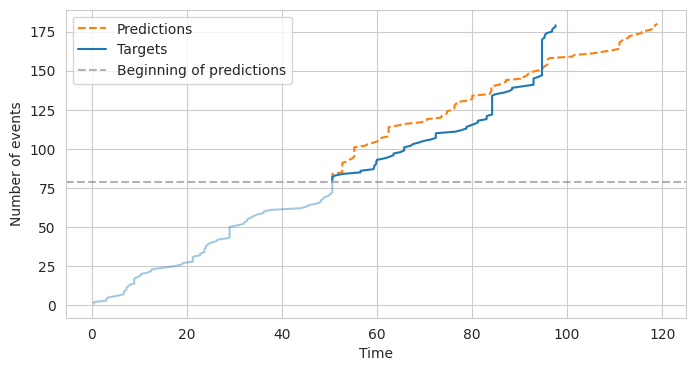

In [9]:
seq = etas(t_end=np.mean(t_end))

n_before = 100
n_preds = n_before

past_seq = seq[:-n_before]

fig, ax = plt.subplots(figsize=(8, 4))

t = past_seq[:, 0]
m = past_seq[:, 1]
preds = model.predict(t, m, n_preds)
t_preds = np.concatenate([[t[-1]], preds[:, 0]])
m_preds = preds[:, 1]
ax.plot(t_preds, t.size + cumsum(t_preds), c='C1',
        label='Predictions', linestyle='--')

seq_size = seq.shape[0]
last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
t_targets = seq[-n_before - 1:last_idx_target, 0]

ax.plot(t, cumsum(t), color='C0', alpha=0.4)
ax.plot(t_targets, t.size + cumsum(t_targets), c='C0', label='Targets')
ax.axhline(y=t.size, linestyle='--', c='gray',
           alpha=0.6, label='Beginning of predictions')

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Number of events')
plt.savefig('../images/beamer/en/etas_preds.png', bbox_inches='tight', dpi=150)

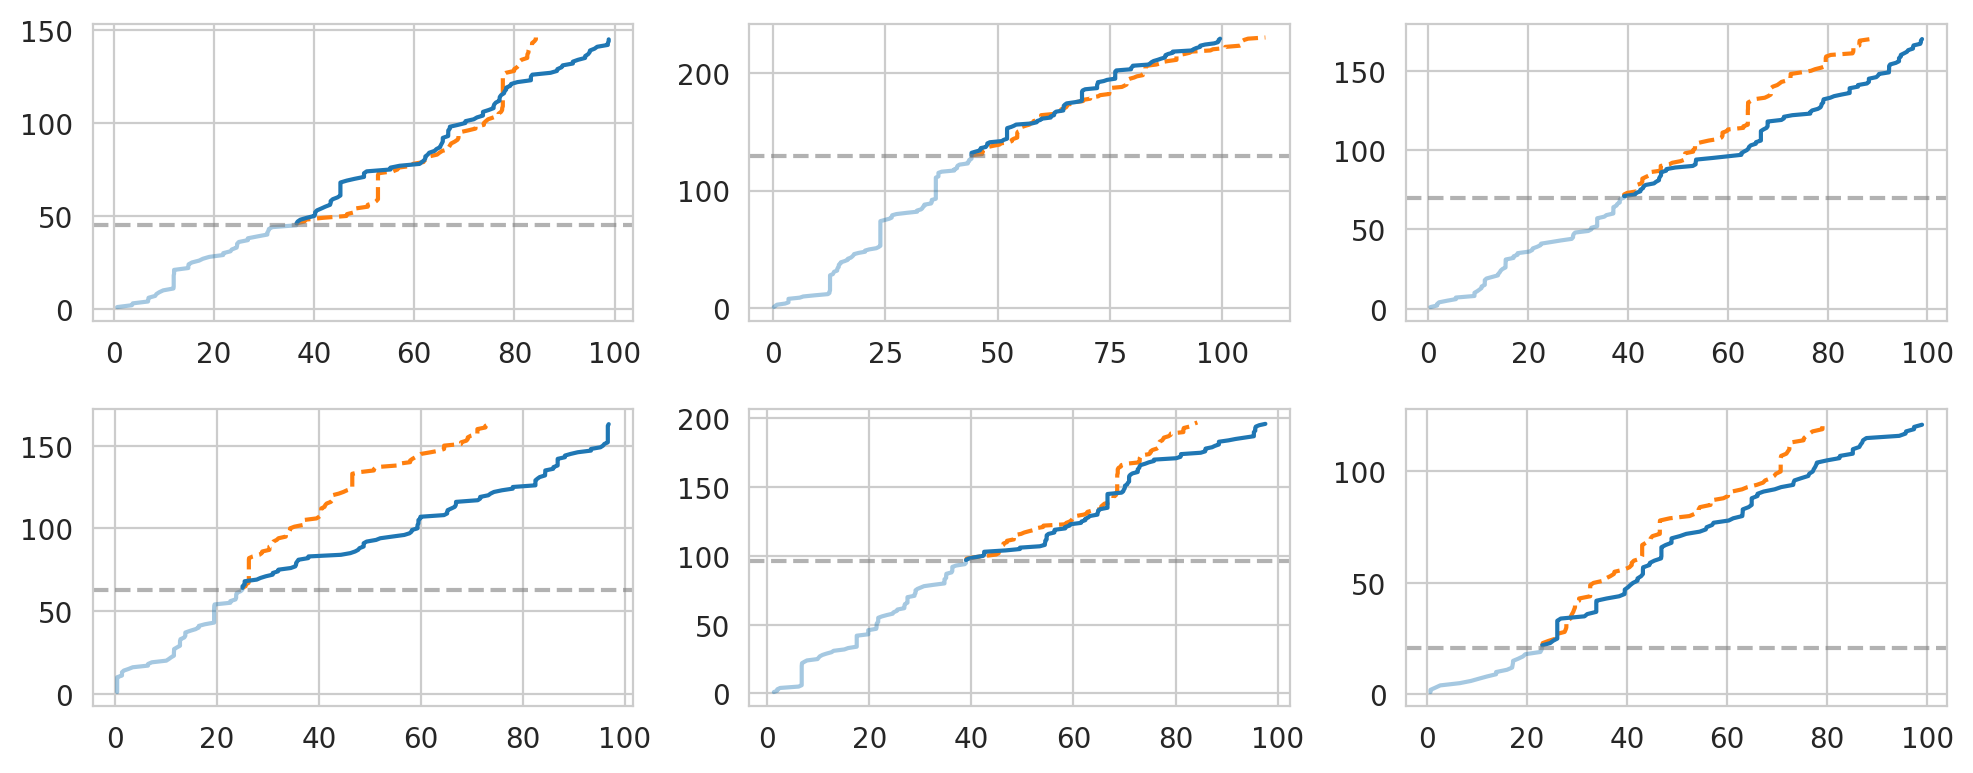

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4), dpi=200)
fig.tight_layout()

for ax in axes.ravel():
    seq = etas(t_end=np.mean(t_end))
    n_before = 100
    n_preds = n_before

    past_seq = seq[:-n_before]

    t = past_seq[:, 0]
    m = past_seq[:, 1]
    preds = model.predict(t, m, n_preds)
    t_preds = np.concatenate([[t[-1]], preds[:, 0]])
    m_preds = preds[:, 1]
    ax.plot(t_preds, t.size + cumsum(t_preds), c='C1', linestyle='--')

    seq_size = seq.shape[0]
    last_idx_target = min(seq_size - 1, seq_size - n_before + n_preds)
    t_targets = seq[-n_before - 1:last_idx_target, 0]

    ax.plot(t, cumsum(t), color='C0', alpha=0.4)
    ax.plot(t_targets, t.size + cumsum(t_targets), c='C0')
    ax.axhline(y=t.size, linestyle='--', c='gray', alpha=0.6)

plt.savefig('../images/beamer/en/etas_preds_mult.png',
            bbox_inches='tight', dpi=200)

In [4]:
seqs, (inter_times, magnitudes, seq_lengths, t_end) = generate_dataset(
    batch_size=100, max_len=250, t_end=100)

model = Model(C=32, dist=Weibull, R=5, dropout_rate=0.5, strategy='log_tau')
history = model.fit(inter_times, seq_lengths, t_end, 200,
                    magnitudes, verbose=1)

Loss at epoch    1:   -7.367
Loss at epoch   10:   -8.980
Loss at epoch   20:   -9.406
Loss at epoch   30:   -9.574
Loss at epoch   40:   -9.710
Loss at epoch   50:   -9.848
Loss at epoch   60:   -9.971
Loss at epoch   70:  -10.098
Loss at epoch   80:  -10.200
Loss at epoch   90:  -10.296
Loss at epoch  100:  -10.356
Loss at epoch  110:  -10.412
Loss at epoch  120:  -10.457
Loss at epoch  130:  -10.491
Loss at epoch  140:  -10.520
Loss at epoch  150:  -10.559
Loss at epoch  160:  -10.588
Loss at epoch  170:  -10.624
Loss at epoch  180:  -10.641
Loss at epoch  190:  -10.674
Loss at epoch  200:  -10.685


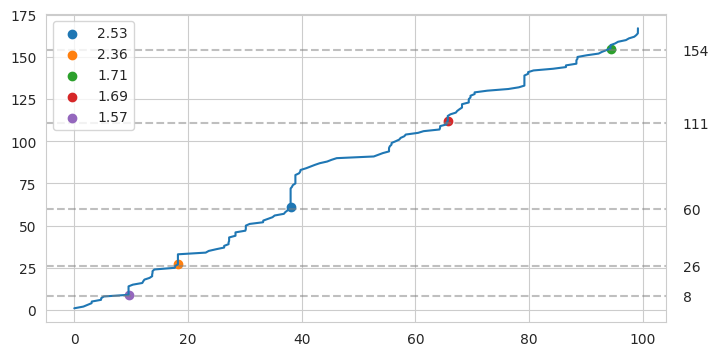

In [11]:
seq = etas(t_end=100)
df = pd.DataFrame(seq, columns=['time', 'magnitude', 'parent'])
idx = df.magnitude.sort_values(ascending=False).iloc[:5].index
plt.figure(figsize=(8, 4))
plt.plot(df.time, df.index + 1)
for i in idx:
    plt.axhline(i, linestyle='--', color='gray', alpha=0.5)
    t = df.time.iloc[i]
    m = df.magnitude.iloc[i]
    plt.text(107, i - 3, i)
    plt.scatter(t, i + 1, label=f'{m:.2f}')
plt.legend()
plt.savefig('../images/beamer/en/etas_mag.png', dpi=200, bbox_inches='tight')
plt.show()

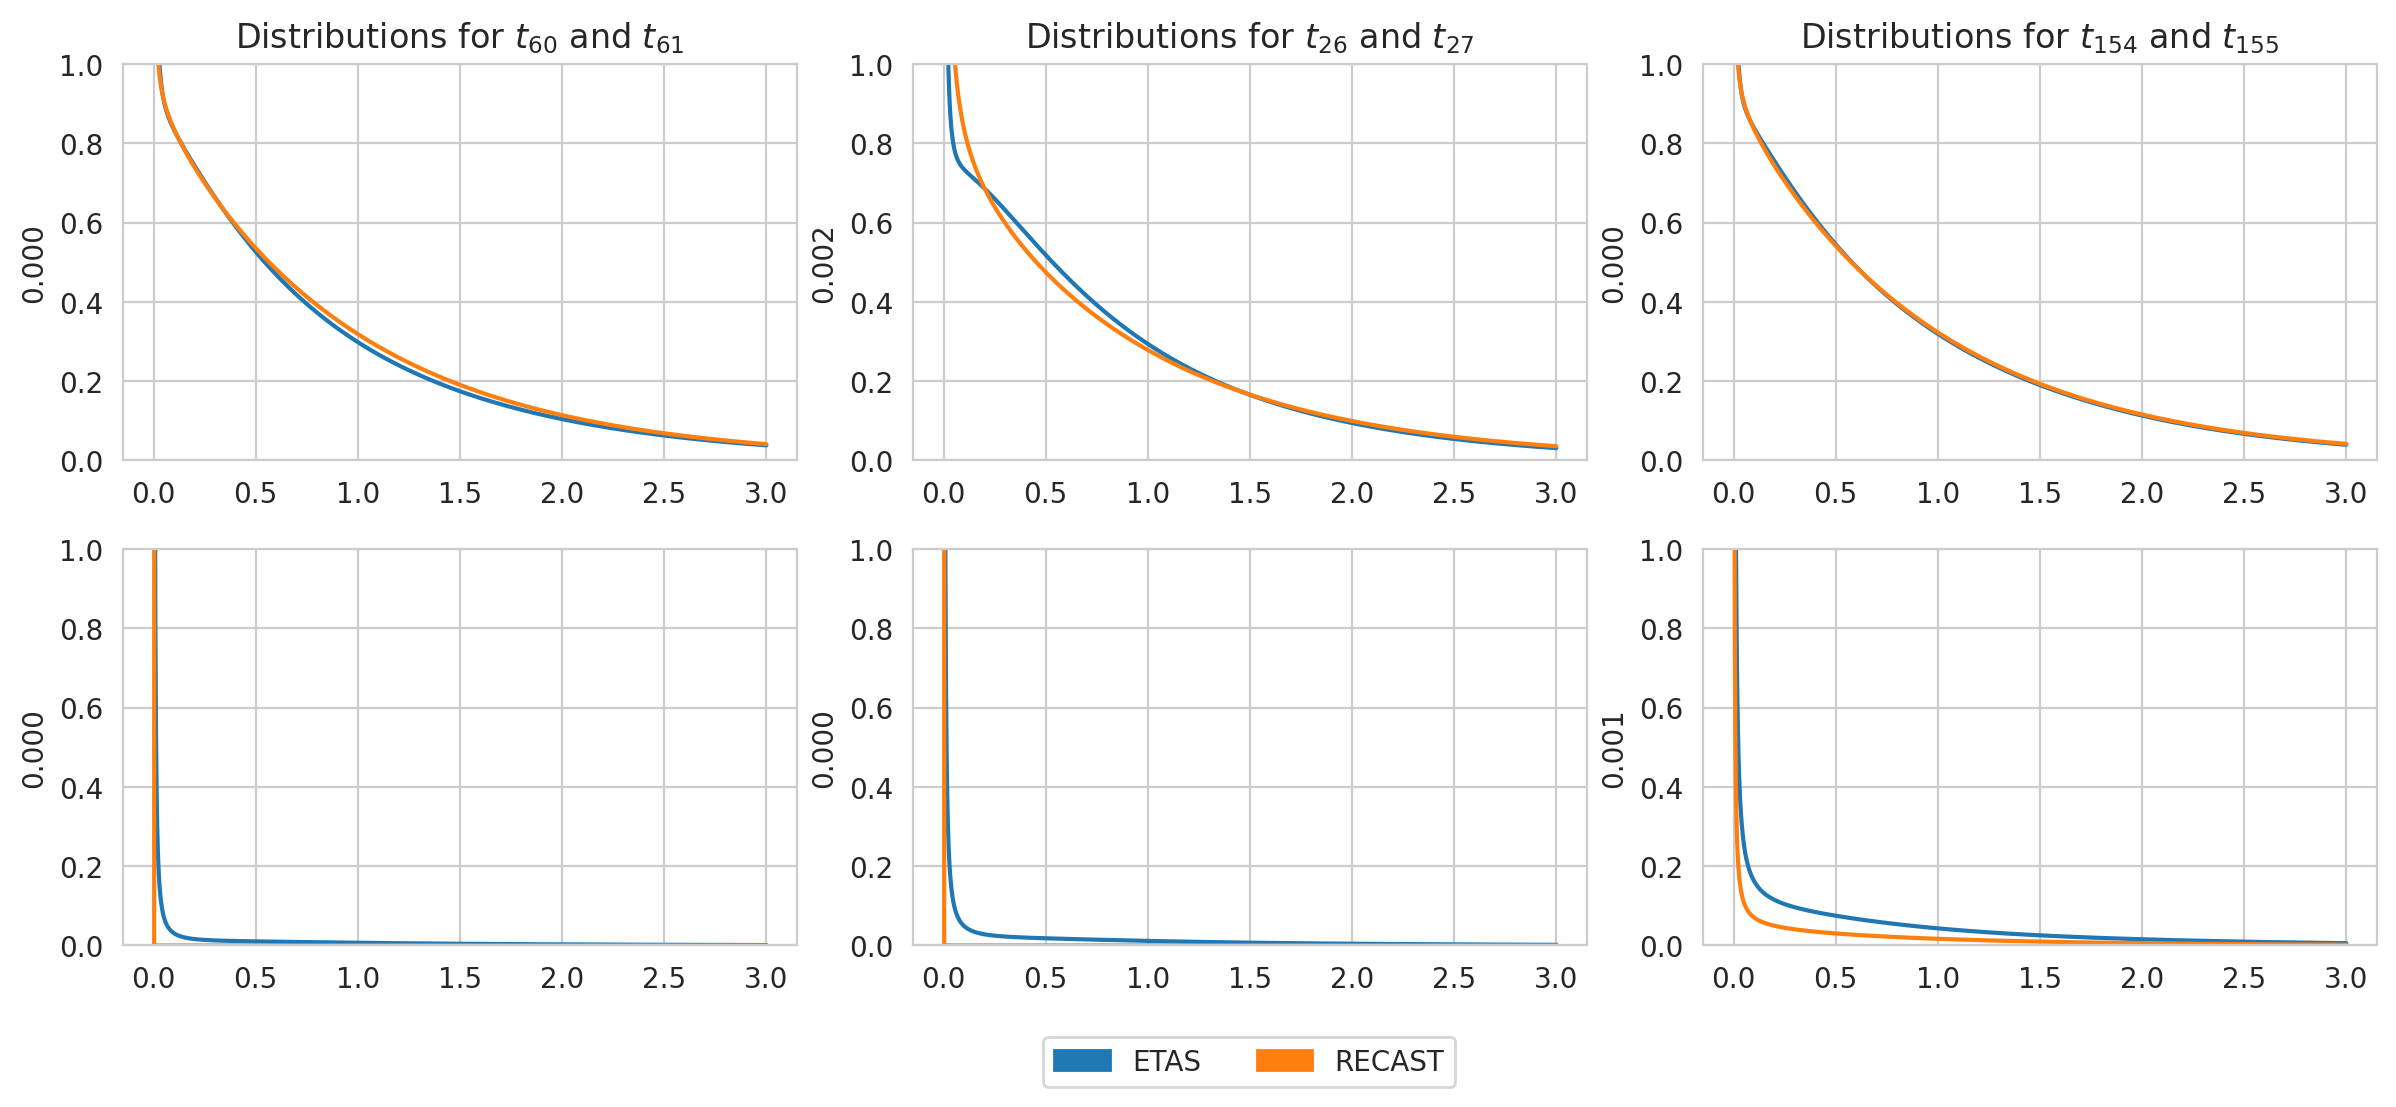

In [13]:
idx = df.magnitude.sort_values(ascending=False).iloc[:3].index
fig, axes = plt.subplots(2, len(idx), figsize=(12, 5), dpi=200)
fig.tight_layout()

for i, id in enumerate(idx):
    qdiff = []
    sub_seq = seq[:id]
    t = sub_seq[:, 0]
    m = sub_seq[:, 1]

    recast_dist = model.predict(t, m, 1, True)[1][0]
    etas_dist = ETAS(t, m)
    x = np.linspace(0, 3, 1000)
    y1 = recast_dist.prob(x)
    y2 = etas_dist.prob(x)
    axes[0, i].plot(x, y1)
    axes[0, i].plot(x, y2)

    axes[0, i].set_ylabel(f'{np.mean((y1[10:] - y2[10:]) ** 2):.3f}')

    sub_seq = seq[:id + 1]
    t = sub_seq[:, 0]
    m = sub_seq[:, 1]
    recast_dist = model.predict(t, m, 1, True)[1][0]
    etas_dist = ETAS(t, m)

    recast_dist = model.predict(t, m, 1, True)[1][0]
    etas_dist = ETAS(t, m)
    x = np.linspace(0, 3, 1000)
    y1 = recast_dist.prob(x)
    y2 = etas_dist.prob(x)
    axes[1, i].plot(x, y1)
    axes[1, i].plot(x, y2)

    axes[1, i].set_ylabel(f'{np.mean((y1[10:] - y2[10:]) ** 2):.3f}')

    axes[0, i].set_ylim([0, 1])
    axes[1, i].set_ylim([0, 1])
    axes[0, i].set_title(f'Distributions for $t_{{{id}}}$ and $t_{{{id+1}}}$')


left_patch = mpatches.Patch(color='C0', label='ETAS')
right_patch = mpatches.Patch(color='C1', label='RECAST')
fig.legend(handles=[left_patch, right_patch], bbox_to_anchor=[0.6, 0], ncol=2)
plt.savefig('../images/beamer/en/cmp_dist_mult.png', dpi=200, bbox_inches='tight')
plt.show()

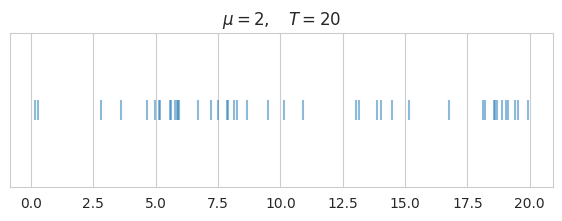

In [14]:
T = 20
mu = 2
seq = poisson(T=T, mu=mu)
plt.figure(figsize=(7, 2))
plt.scatter(seq, np.zeros(seq.size), marker='|', s=200, c='C0', alpha=.5)
plt.yticks([], [])
plt.title(f'$\mu = {mu},\quad T = {T}$')
plt.savefig('../images/beamer/en/poisson.png', dpi=200, bbox_inches='tight')
plt.show()

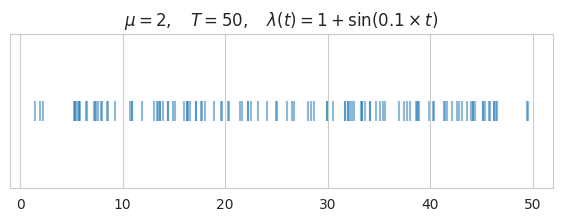

In [15]:
T = 50
mu = 2
seq = poisson_inh(T=T, mu=mu)
plt.figure(figsize=(7, 2))
plt.scatter(seq, np.zeros(seq.size), marker='|', s=200, c='C0', alpha=.5)
plt.yticks([], [])
plt.title(f'$\mu = {mu},\quad T = {T},\quad \
\lambda(t) = 1 + \sin(0.1 \\times t)$')
plt.savefig('../images/beamer/en/poisson_inh.png', dpi=200, bbox_inches='tight')
plt.show()

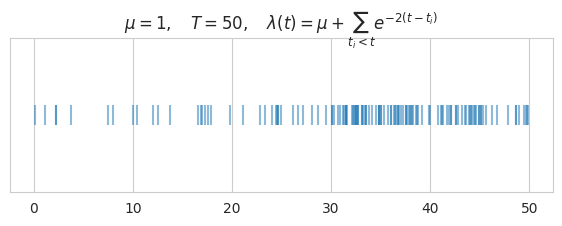

In [16]:
T = 50
mu = 1
alpha = 1
beta = 2
seq = hawkes(T=T, mu=mu, alpha=alpha, beta=beta)
plt.figure(figsize=(7, 2))
plt.scatter(seq, np.zeros(seq.size), marker='|', s=200, c='C0', alpha=.5)
plt.yticks([], [])
plt.title(f'$\mu = {mu},\quad T = {T},\quad \
\lambda(t) = \mu + \sum_{{t_i < t}} e^{{-2 (t - t_i)}}$')
plt.savefig('../images/beamer/en/hawkes.png', dpi=200, bbox_inches='tight')
plt.show()